# Disclaimer
The following document was made following the course “Intermediate Machine Learning” from Kaggle.
All references can be traced back to the following links: 
- https://www.kaggle.com/learn/intro-tomachine-learning
- https://www.kaggle.com/learn/intermediate-machine-learning

We will use the data from the Intro to Machine learning course as a base for these notes.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer

In [3]:
# Load the data
X_full = pd.read_csv("train.csv")

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll use only numerical predictors
X = X_full.select_dtypes(exclude=['object'])

# Divide data into training (80%) and validation (20%) subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# Missing Values
Most machine learning libraries (including scikit-learn) give an error if you try to build a model using data with missing values. To prevent this we can clean our data with different strategies.

# Choose a Strategy
To choose the best course of action we can take a look into our data beforehand. With the following code we can check the number of missing values and compare it with the whole Data Set.

In [4]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(1168, 37)
LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


## Analyse data
Does the dataset have a lot of missing values, or just a few? 
Would we lose much information if we completely ignored the columns with missing entries?

Since there are relatively few missing entries in the data, we can expect that dropping columns is unlikely to yield good results. This is because we'd be throwing away a lot of valuable data, and so imputation will likely perform better.

## 1) Drop Columns with Missing Values
The simplest option is to drop columns with missing values. Unless most values in the dropped columns are missing, the model loses access to a lot of (potentially useful!) information with this approach. As an extreme example, consider a dataset with 10,000 rows, where one important column is missing a single entry. This approach would drop the column entirely!

Since we are working with both training and validation sets, we are careful to drop the same columns in both DataFrames.

In [5]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns 
                     if X_train[col].isnull().any()]

# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print("MAE from Approach 1 (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop columns with missing values):
17952.591404109586


## 2) Imputation
Imputation fills in the missing values with some number. For instance, we can fill in the mean value along each column. The imputed value won't be exactly right in most cases, but it usually leads to more accurate models than you would get from dropping the column entirely.

We use SimpleImputer to replace missing values with the mean value along each column. While the substitution for its mean value is the default approach, there are other strategies: median, most_frequent, constant, etc.

Although it's simple, filling in the mean value generally performs quite well (but this varies by dataset). While statisticians have experimented with more complex ways to determine imputed values (such as regression imputation, for instance), the complex strategies typically give no additional benefit once you plug the results into sophisticated machine learning models.

In [6]:
# Imputation
# Define how missing values will be handled: mean, median, most_frequent, constant...
my_imputer = SimpleImputer()
# Fit: Calculates the replacement values (e.g. column means) from X_train.
# Transform: Fills in the missing values in X_train using those calculated values.
# Wrapping it in pd.DataFrame() converts the result (a NumPy array) back into a DataFrame.
# You could add ", columns=X_train.columns)" to preserve the column names or do it later as you can see in the code.
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
# Applies the same imputation logic to your validation set.
# Uses the values learned from X_train — not recalculated from X_valid.
# This is crucial for avoiding data leakage in ML workflows.
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print("MAE from Approach 2 (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE from Approach 2 (Imputation):
18250.608013698627


### Numerical Variables
Imputation can be used in features with numerical values. These are variables that represent measurable quantities.

Types:
- Continuous: Can take any value within a range.
- Discrete: Represent counts or whole numbers.

## Result analysis
Did removing missing values yield a larger or smaller MAE than imputation? Does this agree with the coding example from the tutorial?

Given that there are so few missing values in the dataset, we'd expect imputation to perform better than dropping columns entirely. However, we see that dropping columns performs slightly better! While this can probably partially be attributed to noise in the dataset, another potential explanation is that the imputation method is not a great match to this dataset. That is, maybe instead of filling in the mean value, it makes more sense to set every missing value to a value of 0, to fill in the most frequently encountered value, or to use some other method. For instance, consider the GarageYrBlt column (which indicates the year that the garage was built). It's likely that in some cases, a missing value could indicate a house that does not have a garage. Does it make more sense to fill in the median value along each column in this case? Or could we get better results by filling in the minimum value along each column? It's not quite clear what's best in this case, but perhaps we can rule out some options immediately - for instance, setting missing values in this column to 0 is likely to yield horrible results!

## 3) An Extension To Imputation
Imputation is the standard approach, and it usually works well. However, imputed values may be systematically above or below their actual values (which weren't collected in the dataset). Or rows with missing values may be unique in some other way. In that case, your model would make better predictions by considering which values were originally missing. In this approach, we impute the missing values, as before. And, additionally, for each column with missing entries in the original dataset, we add a new column that shows the location of the imputed entries. In some cases, this will meaningfully improve results. In other cases, it doesn't help at all.

We impute the missing values, while also keeping track of which values were imputed.

In [7]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print("MAE from Approach 3 (An Extension to Imputation):")
print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid))

MAE from Approach 3 (An Extension to Imputation):
18253.31479452055


## Conclusion
As we see the approach 1 is better than 2, that is better than 3 (we want the MAE to be as low as possible). Generally it should be the other way around. But for the data used in this example is the other way around. Why is this? Imagine a training data that has 10864 rows and 12 columns, where three columns contain missing data. For each column, less than half of the entries are missing. Thus, dropping the columns removes a lot of useful information, and so it makes sense that imputation would perform better. 

This is why is interesting to always validate your approach before commiting.

In [8]:
print("MAE from Approach 1 (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

print("MAE from Approach 2 (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

print("MAE from Approach 3 (An Extension to Imputation):")
print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid))

MAE from Approach 1 (Drop columns with missing values):
17952.591404109586
MAE from Approach 2 (Imputation):
18250.608013698627
MAE from Approach 3 (An Extension to Imputation):
18253.31479452055


# Generate test predictions
After selecting the strategy, we can make our prediction. But first we will need to clean the test data as we did with our training and validation data.

In [9]:
# Read the data
X_test_full = pd.read_csv('test.csv')

# To keep things simple, we'll use only numerical predictors
X_test = X_test_full.select_dtypes(exclude=['object'])

# Add missing indicators to test data
for col in cols_with_missing:
    X_test[col + '_was_missing'] = X_test[col].isnull()

# Align column order before imputation
X_test = X_test[imputed_X_train_plus.columns]

# Preprocess test data
final_X_test = pd.DataFrame(my_imputer.transform(X_test), columns=X_test.columns)

model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(imputed_X_train_plus, y_train)

# Apply same imputation to test data
final_X_test = pd.DataFrame(my_imputer.transform(X_test), columns=X_test.columns)

# Predict
preds_test = model.predict(final_X_test)

# Categorical Variables
Variables that represent categories or groups. Trying to pass these variables into most Python machine learning models without preprocessing will result in an error. To prevent it we can choose one of the approches we will disclose below.

Types:
- Nominal: Categories without inherent order. If people responded to a survey about which what brand of car they owned, the responses would fall into categories like "Honda", "Toyota", and "Ford"
- Ordinal: Categories with a meaningful order. A survey may ask for your satisfaction with a service and give you the following options:

        Ex	Excellent
        Gd	Good
        TA	Average/Typical
        Fa	Fair
        Po	Poor

## Identify categorical features

To identify the categorical features in our data frame, we can check the data type (or `dtype`) of each column. The `object` `dtype` indicates a column has text (there are other things it could theoretically be, but that's unimportant for our purposes). For this dataset, the columns with text indicate categorical variables.

In [10]:
# For this example, we will recover the categorical values.
X = X_full.copy()

# Divide data into training (80%) and validation (20%) subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


## 1) Drop Categorical Variables
The easiest approach to dealing with categorical variables is to simply remove them from the dataset. This approach will only work well if the columns did not contain useful information.

In [11]:
drop_X_train = X_train.select_dtypes(exclude=['object']).copy()
drop_X_valid = X_valid.select_dtypes(exclude=['object']).copy()

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
18407.58712328767


## 2) Ordinal Encoding
Ordinal encoding assigns each unique value to a different integer.

        Ex	Excellent         4
        Gd	Good              3
        TA	Average/Typical   2
        Fa	Fair              1
        Po	Poor              0

This approach assumes an ordering of the categories. Eventhough it makes sense in this example, not all categorical variables have a clear ordening in the values. For tree-based models (like decision trees and random forests), you can expect ordinal encoding to work well with ordinal variables.

Scikit-learn has an `OrdinalEncoder` class that can be used to get ordinal encodings. We loop over the categorical variables and apply the ordinal encoder separately to each column. 

Fitting an ordinal encoder to a column in the training data creates a corresponding integer-valued label for each unique value that appears in the training data. In the case that the validation data contains values that don't also appear in the training data, the encoder will throw an error, because these values won't have an integer assigned to them. To prevent this error we can set `handle_unknown='use_encoded_value'` and `unknown_value=-1` to handle new categories.

In [12]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
# Set handle_unknown='use_encoded_value' and unknown_value to handle new categories
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])

print("MAE from Approach 2 (Ordinal Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Ordinal Encoding):
17332.056643835618


In the code cell above, for each column, we randomly assign each unique value to a different integer. This is a common approach that is simpler than providing custom labels. However, we can expect an additional boost in performance if we provide better-informed labels for all ordinal variables.

We could make an ordinal map with the values we want to give to each category, and then make a loop to assign each feature accordingly. Following our first example:

```Python
ordinal_map = {
    'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0
}
ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual', 'FireplaceQu']

for col in ordinal_cols:
    if col in features_names.columns:
        features_names[col] = features_names[col].map(ordinal_map)
```

Another approach would be to drop the problematic categorical columns. The following code identifies these columns as `bad_label_cols`, and dops them from the data frame.

```Python
# Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_valid[col]).issubset(set(X_train[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)
```

## 3) One-Hot Encoding
One-hot encoding creates new columns indicating the presence (or absence) of each possible value in the original data. To understand this, we'll work through an example.

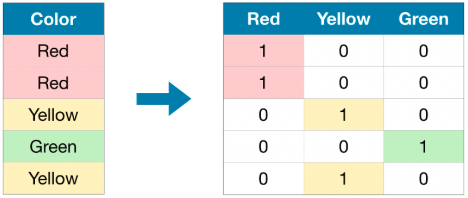

In the original dataset, "Color" is a categorical variable with three categories: "Red", "Yellow", and "Green". The corresponding one-hot encoding contains one column for each possible value, and one row for each row in the original dataset. Wherever the original value was "Red", we put a 1 in the "Red" column; if the original value was "Yellow", we put a 1 in the "Yellow" column, and so on.

In contrast to ordinal encoding, one-hot encoding does not assume an ordering of the categories. Thus, you can expect this approach to work particularly well if there is no clear ordering in the categorical data (e.g., "Red" is neither more nor less than "Yellow"). We refer to categorical variables without an intrinsic ranking as nominal variables.

One-hot encoding generally does not perform well if the categorical variable takes on a large number of values (i.e., you generally won't use it for variables taking more than 15 different values).

We use the `OneHotEncoder` class from scikit-learn to get one-hot encodings. There are a number of parameters that can be used to customize its behavior.

- We set `handle_unknown='ignore'` to avoid errors when the validation data contains classes that aren't represented in the training data,
- setting `sparse_output=False` ensures that the encoded columns are returned as a numpy array (instead of a sparse matrix).

To use the encoder, we supply only the categorical columns that we want to be one-hot encoded. For instance, to encode the training data, we supply `X_train[object_cols]`. 
`object_cols` in the code cell below is a list of the column names with categorical data, and so `X_train[object_cols]` contains all of the categorical data in the training set.

In [13]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# Ensure all columns have string type
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)

print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 3 (One-Hot Encoding):
17491.447979452056


To use this approach we need to identify for each column with categorical data, the number of unique values in the column. We refer to the number of unique entries of a categorical variable as the cardinality of that categorical variable. For instance, the `Street` variable has cardinality 2: `Grvl` and `Pave`.

In [14]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Street', 2),
 ('Alley', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('LandSlope', 3),
 ('MasVnrType', 3),
 ('GarageFinish', 3),
 ('PavedDrive', 3),
 ('PoolQC', 3),
 ('MiscFeature', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('ExterQual', 4),
 ('BsmtQual', 4),
 ('BsmtCond', 4),
 ('BsmtExposure', 4),
 ('KitchenQual', 4),
 ('Fence', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Electrical', 5),
 ('FireplaceQu', 5),
 ('GarageQual', 5),
 ('GarageCond', 5),
 ('Condition2', 6),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('BsmtFinType1', 6),
 ('BsmtFinType2', 6),
 ('Heating', 6),
 ('Functional', 6),
 ('GarageType', 6),
 ('SaleCondition', 6),
 ('RoofMatl', 7),
 ('HouseStyle', 8),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

For large datasets with many rows, one-hot encoding can greatly expand the size of the dataset. For this reason, we typically will only one-hot encode columns with relatively low cardinality. Then, high cardinality columns can either be dropped from the dataset, or we can use ordinal encoding.

As an example, consider a dataset with 10,000 rows, and containing one categorical column with 100 unique entries.

If this column is replaced with the corresponding one-hot encoding, how many entries are added to the dataset?
$1e4*100 - 1e4$

If we instead replace the column with the ordinal encoding, how many entries are added?
None.

The following code separates the columns with a cardinality lower than 10 to be encoded and equal or higher than 10 to be dropped from the dataset.

In [15]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Exterior1st', 'Exterior2nd', 'Neighborhood']


### Conclusion
As we see the approach 2 is better than 3, that is better than 1. In general, one-hot encoding (Approach 3) will typically perform best, and dropping the categorical columns (Approach 1) typically performs worst, but it varies on a case-by-case basis.

In [16]:
print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

print("MAE from Approach 2 (Ordinal Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
18407.58712328767
MAE from Approach 2 (Ordinal Encoding):
17332.056643835618
MAE from Approach 3 (One-Hot Encoding):
17491.447979452056


# Pipelines
Before fitting our model with our selected features, it is a good practise to use a pipeline. This ensures that all data preprocessing steps (like handling missing values, scaling, and encoding) are applied consistently and correctly. Meaning that the data is handled in a way that the model can learn effectively. Pipelines are a simple way to keep your data preprocessing and modeling code organized. Specifically, a pipeline bundles preprocessing and modeling steps so you can use the whole bundle as if it were a single step. Pipelines have some important benefits:
- Cleaner Code: Accounting for data at each step of preprocessing can get messy. With a pipeline, you won't need to manually keep track of your training and validation data at each step.
- Fewer Bugs: There are fewer opportunities to misapply a step or forget a preprocessing step.
- Easier to Productionize: It can be surprisingly hard to transition a model from a prototype to something deployable at scale. Pipelines can ease this.
- More Options for Model Validation: cross-validation.

In conclusion, a pipeline guarantees that the data is cleaned, transformed, and prepared in the exact same way every time, whether you're training, validating, or predicting. It prevents errors, avoids data leakage, and keeps your workflow organized and reproducible. Without it, you risk applying inconsistent transformations, leaking test data into training, or forgetting key steps. With it, your model gets reliable input, and your code stays clean and scalable.

## Step 1: Define Preprocessing Steps
Similar to how a pipeline bundles together preprocessing and modeling steps, we use the ColumnTransformer class to bundle together different preprocessing steps. The code below:
- imputes missing values in numerical data, and
- imputes missing values and applies a one-hot encoding to categorical data.

### Numerical Variables
To transform the numerical variables, we have selected the `SimpleImputer(strategy='constant')`. Replaces missing values with `fill_value`. Can be used with strings or numeric data. If `fill_value` is not defined (`fill_value=None`), it will be 0 when imputing numerical data and “missing_value” for strings or object data types.

This is only one of many strategies, to improve our model is good to try different strategies:

`SimpleImputer(strategy='median')`: replaces missing values with the median of that column.
The scale selected is `StandardScaler()` to prevent the misrepresentation of large values.

```Python
# Numerical Variables: imput + scale
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
```

In [17]:
# Reset traning and validation data rto prevent errors
X = X_full.copy()

# Divide data into training (80%) and validation (20%) subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Since we already identified the categorical columns, we will use a copy and extract them to identify the numerical columns
categorical_cols = object_cols.copy()
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

Here is another way to select our data types:
```python
# Select categorical columns with relatively low cardinality (number of unique values in a column)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]
```

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

### Categorical Variables
Most ML models (like linear regression, decision trees, etc.) can’t handle text or categories directly, that is why it is a good practise to transform this kind of variables beforehand. It’s especially useful when categories do not have a natural order, as in our case.

`SimpleImputer(strategy='most_frequent')`: Fills in missing values using the most common value in each column, since models can't handle missing values directly. Using the most frequent value avoids introducing outliers or unrealistic replacements.
`OneHotEncoder(handle_unknown='ignore')`: Converts categorical variables into binary columns. `handle_unknown='ignore'` is used to avoid errors when new categories appear in test data.

In [19]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

### Transformation designation
The following code indicates which columns require to be transformed and how before feeding them into a machine learning model.

The final line `remainder='passthrough'` it is added so that the columns not specified are processed without any transformation.

In [20]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='passthrough')

## Step 2: Define the Model
Next, we define a random forest model with the familiar `RandomForestRegressor` class.

In [21]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)

## Step 3: Create and Evaluate the Pipeline
Finally, we use the `Pipeline` class to define a pipeline that bundles the preprocessing and modeling steps. There are a few important things to notice:

- With the pipeline, we preprocess the training data and fit the model in a single line of code. In contrast, without a pipeline, we have to do imputation, one-hot encoding, and model training in separate steps. This becomes especially messy if we have to deal with both numerical and categorical variables.
- With the pipeline, we supply the unprocessed features in `X_valid` to the `predict()` command, and the pipeline automatically preprocesses the features before generating predictions. However, without a pipeline, we have to remember to preprocess the validation data before making predictions.

To create our model, we will need to define:
- Type of model: In our case a Random Forest, defined in the Step 2.
- Fit: Capture patterns from provided data.
- Predict: The value to be obtained.
- Evaluate: Determine how accurate the model's predictions are.

In [22]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 17683.50743150685


## Step 4: Predictions
Now that we have succesfully created our pipeline and evaluated its performance, we can use our test data. As you can see we greratly reduced our code from previous iterations.

In [23]:
# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test_full)

# Cross-Validation
So far we have chosen the pedictive variables to use, types of model, arguments to apply in said models, etc. The issue with this approach is that we will typically hold about 20% of the data as a validation dataset. This means that small datasets will have less validation data to the point that comparing alternative models for the best prediction would be mostly a matter of luck.

In general, the larger the validation set, the less randomness (aka "noise") there is in our measure of model quality, and the more reliable it will be. Unfortunately, we can only get a large validation set by removing rows from our training data, and smaller training datasets mean worse models.

In cross-validation, we run our modeling process on different subsets of the data to get multiple measures of model quality.

For example, we could begin by dividing the data into 5 pieces, each 20% of the full dataset. In this case, we say that we have broken the data into 5 "folds".

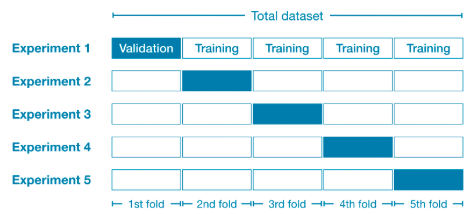

- In Experiment 1, we use the first fold as a validation (or holdout) set and everything else as training data. This gives us a measure of model quality based on a 20% holdout set.
- In Experiment 2, we hold out data from the second fold (and use everything except the second fold for training the model). The holdout set is then used to get a second estimate of model quality.
- We repeat this process, using every fold once as the holdout set. Putting this together, 100% of the data is used as holdout at some point, and we end up with a measure of model quality that is based on all of the rows in the dataset (even if we don't use all rows simultaneously).

Cross-validation gives a more accurate measure of model quality, which is especially important if you are making a lot of modeling decisions. However, it can take longer to run, because it estimates multiple models (one for each fold). So, when should you use each approach?

- For small datasets, where extra computational burden isn't a big deal, you should run cross-validation.
- For larger datasets, a single validation set is sufficient. Your code will run faster, and you may have enough data that there's little need to re-use some of it for holdout.

There's no simple threshold for what constitutes a large vs. small dataset. But if your model takes a couple minutes or less to run, it's probably worth switching to cross-validation.

Alternatively, you can run cross-validation and see if the scores for each experiment seem close. If each experiment yields the same results, a single validation set is probably sufficient.

To apply this method, first we define a pipeline that uses an imputer to fill in missing values and a random forest model to make predictions. While it's possible to do cross-validation without pipelines, it is quite difficult. Using a pipeline will make the code remarkably straightforward.

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Reset traning and validation data rto prevent errors
X = X_full.copy()

# Divide data into training (80%) and validation (20%) subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])

We obtain the cross-validation scores with the `cross_val_score()` function from scikit-learn. We set the number of folds with the `cv` parameter.

The scoring parameter chooses a measure of model quality to report: in this case, we chose negative mean absolute error (MAE) `neg_mean_absolute_error`. It is a little surprising that we specify negative MAE. Scikit-learn has a convention where all metrics are defined so a high number is better. Using negatives here allows them to be consistent with that convention, though negative MAE is almost unheard of elsewhere.

We typically want a single measure of model quality to compare alternative models. So we take the average across experiments.

We could also use other scoring techniques like `scoring='accuracy'`. We would also need to represent the final value as the mean of all the results.

In [25]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

print("Average MAE score (across experiments):")
print(scores.mean())

MAE scores:
 [17869.73856164 17984.53253425 18127.52842466 16435.23383562
 19349.02917808]
Average MAE score (across experiments):
17953.21250684931


We could create the following function to check the score of this methodology.

In [26]:
def get_score(n_estimators):

    my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators, random_state=0))
    ])
    
    scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=3,
                              scoring='neg_mean_absolute_error')

    # print("MAE scores:\n", scores)
    return scores.mean()

In order to better visualize the results of our model, we can storage our results in a python dictionary and plot it as it follows.

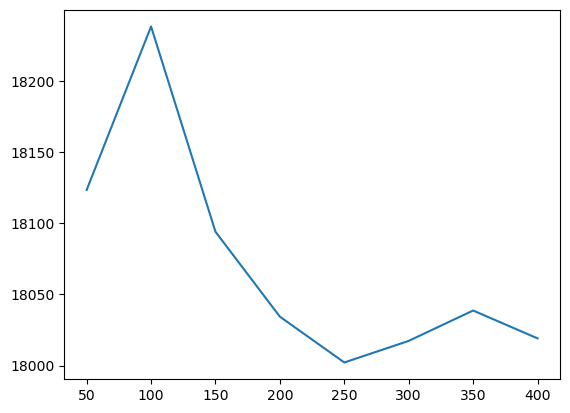

In [27]:
results = {}
# Evaluate the model performance corresponding to eight different values for the number of trees in the random forest: 
# 50, 100, 150, ..., 300, 350, 400.
for i in range(1,9):
    results[50*i] = get_score(50*i)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

## Conclusion
Using cross-validation yields a much better measure of model quality, with the added benefit of cleaning up our code: note that we no longer need to keep track of separate training and validation sets. So, especially for small datasets, it's a good improvement.

# XGBoost
So far, we have been using the random forest method as an "ensemble method". By definition, ensemble methods combine the predictions of several models (e.g., several trees, in the case of random forests).

Next, we'll learn about another ensemble method called **gradient boosting**. Gradient boosting is a method that goes through cycles to iteratively add models into an ensemble.

It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. But even if its predictions are wildly inaccurate, subsequent additions to the ensemble will address those errors.

Then, we start the cycle:
- First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we add the predictions from all models in the ensemble.
- These predictions are used to calculate a loss function (like mean squared error, for instance).
- Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss. The "gradient" in "gradient boosting" refers to the fact that we'll use gradient descent on the loss function to determine the parameters in this new model.
- Finally, we add the new model to ensemble, and ...
- ... repeat!

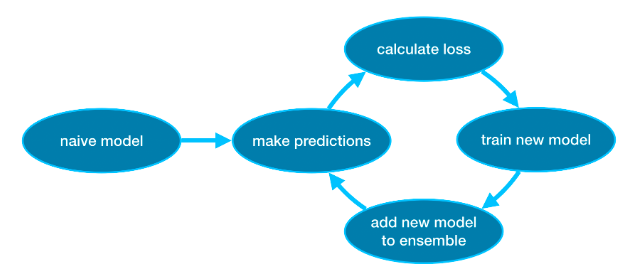

XGBoost is a leading software library for working with standard tabular data (the type of data you store in Pandas DataFrames, as opposed to more exotic types of data like images and videos). With careful parameter tuning, you can train highly accurate models.

In [28]:
# If you run into an error, install the xgboost package first
# !pip install xgboost

import xgboost as xgb
from xgboost import XGBRegressor

Since XGBoost does not work with categorical variables, we can either transform them as we already explained, or we can try to use the XGBoost's experimental categorical feature support. We would need to first modify the categorical columns class to `'category'` and `enable_categorical=True`. If we do not do this previous step, we will run into the error "DataFrame.dtypes for data must be int, float, bool or category.".

In [29]:
categorical_columns = X_train.select_dtypes(include=['object']).columns
for col in categorical_columns:
    X_train[col] = X_train[col].astype('category')

my_model = XGBRegressor(enable_categorical=True)
my_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

**XGBoost** stands for extreme gradient boosting, which is an implementation of gradient boosting with several additional features focused on performance and speed. For this, we need to import the scikit-learn API for XGBoost (`xgboost.XGBRegressor`). The `XGBRegressor` class has many tunable parameters that can dramatically affect accuracy and trainning speed.

## `n_estimators`

Specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.

- Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
- Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).

Typical values range from 100-1000, though this depends a lot on the learning_rate parameter discussed below.

In [30]:
my_model = XGBRegressor(n_estimators=500, enable_categorical=True)
my_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

## `early_stopping_rounds` 
Offers a way to automatically find the ideal value for `n_estimators`. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for `n_estimators`. It's smart to set a high value for `n_estimators` and then use `early_stopping_rounds` to find the optimal time to stop iterating.

Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration to allow before stopping. Setting `early_stopping_rounds=5` is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.

When using `early_stopping_rounds`, you also need to set aside some data for calculating the validation scores - this is done by setting the `eval_set` parameter. When using `eval_set` we can also fine tune the parameter `verbose`. Verbose is a general programming term for produce lots of logging output. Basically with False (e.g. 0) it does not print anything. With any integer, it will print the evaluation score at that step. So for `verbose=100` it will tell you the score every 100 iterations. Setting `verbose=True` is the same as setting it to 1, which will print everything it is doing, which is a lot.

Trick to check: Set verbose equal to one more than the `n_estimators` value. This is helpful when using `early_stopping`, or training with multiple models as you only get the "best_epoch" logged.

If you later want to fit a model with all of your data, set `n_estimators` to whatever value you found to be optimal when run with early stopping.

NOTE: To use the XGBoost's experimental categorical feature support. We need to first modify the categorical columns class to `'category'` and `enable_categorical=True`. If we do not do this previous step, we will run into the error "DataFrame.dtypes for data must be int, float, bool or category.".

In [34]:
categorical_columns = X_valid.select_dtypes(include=['object']).columns
for col in categorical_columns:
    X_valid[col] = X_valid[col].astype('category')

my_model = XGBRegressor(n_estimators=500, 
                        enable_categorical=True,
                        early_stopping_rounds=5)  # Move parameter to model initialization
my_model.fit(X_train, y_train, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

## `learning_rate`
Instead of getting predictions by simply adding up the predictions from each component model, we can multiply the predictions from each model by a small number (known as the learning rate) before adding them in.

This means each tree we add to the ensemble helps us less. So, we can set a higher value for n_estimators without overfitting. If we use early stopping, the appropriate number of trees will be determined automatically.

In general, a small learning rate and large number of estimators will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle. As default, XGBoost sets `learning_rate=0.1`.

In [36]:
my_model = XGBRegressor(n_estimators=1000, 
                        learning_rate=0.05, 
                        early_stopping_rounds=5, 
                        enable_categorical=True)
my_model.fit(X_train, y_train,  
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

## `n_jobs`
On larger datasets where runtime is a consideration, you can use parallelism to build your models faster. It's common to set the parameter `n_jobs` equal to the number of cores on your machine. On smaller datasets, this won't help.

The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the fit command.

In [37]:
my_model = XGBRegressor(n_estimators=1000, 
                        learning_rate=0.05, 
                        early_stopping_rounds=5, 
                        n_jobs=4, 
                        enable_categorical=True)
my_model.fit(X_train, y_train, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=4, num_parallel_tree=None, ...)

# Data Leakeage
Data leakage (or leakage) happens when your training data contains information about the target, but similar data will not be available when the model is used for prediction. This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production. In other words, leakage causes a model to look accurate until you start making decisions with the model, and then the model becomes very inaccurate.

## Target Leakeage
Target leakage occurs when your predictors include data that will not be available at the time you make predictions. It is important to think about target leakage in terms of the timing or chronological order that data becomes available, not merely whether a feature helps make good predictions.

Imagine you want to predict who will get sick with pneumonia. People take antibiotic medicines after getting pneumonia in order to recover. The raw data shows a strong relationship between those columns, but `took_antibiotic_medicine` is frequently changed after the value for `got_pneumonia` is determined. This is target leakage.

The model would see that anyone who has a value of `False` for `took_antibiotic_medicine` didn't have pneumonia. Since validation data comes from the same source as training data, the pattern will repeat itself in validation, and the model will have great validation (or cross-validation) scores. But the model will be very inaccurate when subsequently deployed in the real world, because even patients who will get pneumonia won't have received antibiotics yet when we need to make predictions about their future health.

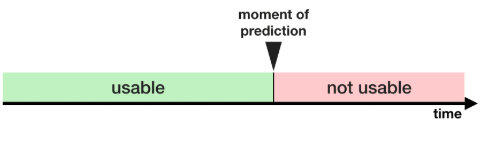

To prevent this type of data leakage, any variable updated (or created) after the target value is realized should be excluded. It's very rare to find models that are accurate 98% of the time. It happens, but it's uncommon enough that we should inspect the data more closely for target leakage. 

We will use the following variables as an example:

    card: 1 if credit card application accepted, 0 if not
    reports: Number of major derogatory reports
    age: Age n years plus twelfths of a year
    income: Yearly income (divided by 10,000)
    share: Ratio of monthly credit card expenditure to yearly income
    expenditure: Average monthly credit card expenditure
    owner: 1 if owns home, 0 if rents
    selfempl: 1 if self-employed, 0 if not
    dependents: 1 + number of dependents
    months: Months living at current address
    majorcards: Number of major credit cards held
    active: Number of active credit accounts

After studying the different variables and identifying the possible conflict, basic data comparisons can be very helpful. 

For example, does `expenditure` mean expenditure on this card or on cards used before applying?

```python
expenditures_cardholders = X.expenditure[y]
expenditures_noncardholders = X.expenditure[~y]

print('Fraction of those who did not receive a card and had no expenditures: %.2f' \
      %((expenditures_noncardholders == 0).mean()))
print('Fraction of those who received a card and had no expenditures: %.2f' \
      %(( expenditures_cardholders == 0).mean()))
---
'Fraction of those who did not receive a card and had no expenditures: 1.00'
'Fraction of those who received a card and had no expenditures: 0.02'
```
Everyone who did not receive a card had no expenditures, while only 2% of those who received a card had no expenditures. It's not surprising that our model appeared to have a high accuracy. But this also seems to be a case of target leakage, where expenditures probably means expenditures on the card they applied for.

Since `share` is partially determined by `expenditure`, it should be excluded too. The variables `active` and `majorcards` are a little less clear, but from the description, they sound concerning. In most situations, it's better to be safe than sorry if you can't track down the people who created the data to find out more.

After identifying the possible conflictive values, we can run a model and check if the accuracy is more feaseable. Even if the accuracy is lower, we can expect it to be more right when used on new applications, whereas the leaky model would likely do much worse than that (in spite of its higher apparent score in cross-validation).

```python
# Drop leaky predictors from dataset
potential_leaks = ['expenditure', 'share', 'active', 'majorcards']
X2 = X.drop(potential_leaks, axis=1)
```

## Train-Test Contamination
A different type of leak occurs when you aren't careful to distinguish training data from validation data. Recall that validation is meant to be a measure of how the model does on data that it hasn't considered before. You can corrupt this process in subtle ways if the validation data affects the preprocessing behavior. This is sometimes called train-test contamination.

For example, imagine you run preprocessing (like fitting an imputer for missing values) before calling train_test_split(). This way your model may get good validation scores, giving you great confidence in it, but perform poorly when you deploy it to make decisions. After all, you incorporated data from the validation or test data into how you make predictions, so it may do well on that particular data even if it can't generalize to new data. This problem becomes even more subtle (and more dangerous) when you do more complex feature engineering.

If your validation is based on a simple train-test split, exclude the validation data from any type of fitting, including the fitting of preprocessing steps. This is easier if you use scikit-learn pipelines. When using cross-validation, it's even more critical that you do your preprocessing inside the pipeline.